<a href="https://colab.research.google.com/github/Zhuoyue-Huang/urop_2022_ml/blob/main/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""Verify the gradient derivation of linear masked autoencoder."""
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import numpy as np
import pandas as pd 
import scipy.stats as stats
from torch.distributions.exponential import Exponential

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# set default to be float64
torch.set_default_dtype(torch.float64)

### Model initialisation

In [4]:
# Linear auto-encoder model
class LAE(nn.Module):
    def __init__(self, n, p):
        super(LAE, self).__init__()
        self.n = n
        self.p = p
        self.w1 = nn.Linear(n, p, bias=False)
        self.w2 = nn.Linear(p, n, bias=False)

    def forward(self, y):
        y = self.w1(y)
        y = self.w2(y)
        return y

In [5]:
## Masked lienar auto-encoder model
# Define different types of masks
def mask_basic(prob, sample_num, x_dim):
    return torch.zeros(sample_num, x_dim).bernoulli_(prob)

def mask_dropping_probs(prob_list: torch.Tensor, sample_num, x_dim):
    return torch.zeros(sample_num, x_dim).bernoulli_(prob_list)

def mask_patches_block(prob, patch_size: torch.Tensor, sample_num, sample_dim: torch.Tensor):
    x_dim = sample_dim[0]*sample_dim[1]
    div_check = sample_dim % patch_size == torch.zeros(2)
    if torch.all(div_check):
        pix_num = torch.div(sample_dim, patch_size, rounding_mode='floor')
        mat_patches = torch.zeros(sample_num, *pix_num).bernoulli_(prob)
        mat_patches = torch.repeat_interleave(mat_patches, patch_size[1], dim=2)
        return mat_patches.repeat_interleave(patch_size[0], dim=1).view(sample_num, x_dim)
    else:
        raise NotImplementedError(f"Both height ({sample_dim[0]}) and width ({sample_dim[1]}) should be divisible by patch_size ({patch_size}).")

def mask_patches_plain(prob, patch_size, sample_num, x_dim):
    if not x_dim % patch_size:
        pix_num = x_dim // patch_size
        mat_patches = torch.zeros(sample_num, pix_num).bernoulli_(prob)
        return mat_patches.repeat_interleave(patch_size, dim=1)
    else:
        raise NotImplementedError

# Masked autoencoder (linear)
class M_LAE(nn.Module):
    def __init__(self, prob, x_dim, f_dim, type='basic', patch_size=None, sample_dim=None):
        super(M_LAE, self).__init__()
        self.prob = prob
        if sample_dim is not None:
            self.sample_dim = sample_dim
            self.H, self.W = sample_dim
            self.n = self.H * self.W
        self.n = x_dim
        self.p = f_dim
        if type not in ['basic', 'probs', 'patches']:
            raise NotImplementedError("Could only implement 'basic', 'probs' and 'patches' type of masking.")
        else:
            self.masking_type = type
        if patch_size is not None:
            self.patch_size = patch_size
        w1 = nn.Linear(self.n, self.p, bias=False)
        w2 = nn.Linear(self.p, self.n, bias=False)
        self.body = nn.Sequential(*[w1, w2])
    
    def forward(self, X, mask=None):
        m = X.shape[0]
        if mask is None:
            if self.masking_type == 'basic':
                mask = mask_basic(self.prob, m, self.n).to(device)
            elif self.masking_type == 'probs':
                mask = mask_dropping_probs(self.prob, m, self.n).to(device)
            elif self.masking_type == 'patches':
                mask = mask_patches_plain(self.prob, self.patch_size, m, self.n).to(device)
        Y = mask * X
        Y = self.body(Y)
        return Y

In [6]:
class FE_Net(nn.Module):
    def __init__(self, f_dim, y_dim):
        super(FE_Net, self).__init__()
        self.theta = nn.Linear(f_dim, y_dim, bias=False)

    def forward(self, W):
        return self.theta(W)

In [7]:
def train_loop(data_dict, model, criterion, optimizer, type, epochs=100, sample_average=10, record=True):
    train_loss = []
    val_loss = []
    if type=='encoder':
        X_train = data_dict['X_train']
        y_train = X_train
    elif type=='fe':
        X_train = data_dict['X_train']
        y_train = data_dict['y_train']
        sample_average = 1

    for epoch in range(epochs+1):
        loss_total = 0
        optimizer.zero_grad()
        for i in range(sample_average):
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss_total += loss
        loss_total /= sample_average
        loss_total.backward()
        optimizer.step()
        if record:
          train_loss.append(loss_total.item())
          if epochs>=20 and epoch%(epochs//20)==0:
              v_loss = test_loop(data_dict, model, criterion, type)
              val_loss.append(v_loss)
              print('epoch: ', epoch, ', train loss: ', loss.item(), ', val loss', v_loss)
    if record:
        return {'train_loss': train_loss, 'val_loss': val_loss}
    else:
        return loss_total.item()

def test_loop(data_dict, model, criterion, type):
    if type=='encoder':
        X = data_dict['X_val']
        y = X
    elif type=='fe':
        X = data_dict['X_test']
        y = data_dict['y_test']

    with torch.no_grad():
        outputs = model(X)
        loss = criterion(outputs, y)
    return loss.item()

In [8]:
# representation learning
def repr_learning(data_dict, model_parameters, criterion, type, epochs=200, device='cuda'):
    X_train, y_train, _, _, X_test, y_test = data_dict.values()

    params = list(model_parameters)
    W1 = params[0].clone().detach()
    f_train = X_train @ W1.T
    f_test = X_test @ W1.T
    f_dim = f_train.shape[1]
    y_dim = y_train.shape[1]

    if type=='ls':
        theta = (torch.inverse(f_train.T @ f_train) @ f_train.T @ y_train).T
        loss = criterion(y_test, f_test @ theta.T)
        return loss.item()
    elif type=='gd':
        data_dict_fe = {'X_train': f_train, 'y_train': y_train,
                        'X_test': f_test, 'y_test': y_test}
        net_fe = FE_Net(f_dim, y_dim).to(device)
        theta = list(net_fe.parameters())
        optimizer = optim.Adam(theta, lr=0.0001)
        ### TRAINING ###
        train_loop(data_dict_fe, net_fe, criterion, optimizer, epochs=epochs, record=False, type='fe')
        loss_fe = test_loop(data_dict_fe, net_fe, criterion, type='fe')
        return loss_fe

### Dataset

In [9]:
train_num, val_num, test_num = (4000, 500, 2000) # larger number of dataset
sample_num_split = (train_num, train_num + val_num)
total = train_num+val_num+test_num

# need to consider f_dim <, =, > z_dim
z_dim = 10 # dimension of z
H = 4
W = 4
sample_dim = torch.tensor([H, W])
x_dim = H * W
f_dim = 13
y_dim = z_dim // 2

prob_search = torch.range(0, 1, 0.05)
prob_list_search = torch.rand(x_dim, generator=torch.random.manual_seed(1911))*0.2\
                   + torch.repeat_interleave(torch.range(0, 0.8, 0.05).unsqueeze(1), x_dim, dim=1)
patch_size_plain_search = torch.tensor([2, 4, 8, 16])
patch_size_block_search = []
for i in [2, 4, 8, 16]:
    for j in [2, 4, 8, 16]:
        patch_size_block_search.append([i, j])
patch_size_search = torch.tensor(patch_size_block_search)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  app.launch_new_instance()


In [10]:
#mean = torch.linspace(0, 5, z_dim).repeat(total, 1)
#std = torch.linspace(3, 8, z_dim).repeat(total, 1)
#m = Exponential(1)
#z = m.rsample((total,z_dim))
#z = torch.normal(mean=mean, std=std, generator=torch.random.manual_seed(1911))
z = torch.normal(mean=0, std=1, size=(total,z_dim), generator=torch.random.manual_seed(1911)) # here distribution is high dimensional guassian
z = z.to(device)

In [11]:
U = torch.rand(x_dim, z_dim, generator=torch.random.manual_seed(1911))
U = U.to(device)
V = torch.rand(y_dim, z_dim, generator=torch.random.manual_seed(1911))
V = V.to(device)

x = z @ U.T
y = z @ V.T
X_train, X_val, X_test = torch.tensor_split(x, sample_num_split)
y_train, y_val, y_test = torch.tensor_split(y, sample_num_split)
data_dict = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val, 'X_test': X_test, 'y_test': y_test}
fe_loss_dict = {'LAE': [], 'MLAE_basic': [], 'MLAE_probs': [], 'MLAE_patches': []}

In [60]:
learning_rate = 0.01
epochs = 1000
epochs_fe = 100
epochs_grid = 50

### Get features from autoencoder

##### Linear autoencoder

In [61]:
fe_loss_dict['LAE'] = []
for i in tqdm(range(epochs_fe)):
    net_LAE = LAE(x_dim, f_dim).to(device)

    params = list(net_LAE.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_LAE = train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    loss_ls = repr_learning(data_dict, net_LAE.parameters(), criterion, type='ls', epochs=epochs)
    fe_loss_dict['LAE'].append(loss_ls)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:  0 , train loss:  3.530960470794398 , val loss 2.8863159468449613
epoch:  50 , train loss:  0.19295041995744067 , val loss 0.1855944433629145
epoch:  100 , train loss:  0.04280071828511353 , val loss 0.04242020778830265
epoch:  150 , train loss:  0.01942103449403477 , val loss 0.01831114114431498
epoch:  200 , train loss:  0.007870408865553978 , val loss 0.007625823267103261
epoch:  250 , train loss:  0.0041361826224946925 , val loss 0.0043094738973569096
epoch:  300 , train loss:  0.003502889106909544 , val loss 0.0036855358785239105
epoch:  350 , train loss:  0.0030153667739091766 , val loss 0.003172680902816611
epoch:  400 , train loss:  0.0024716411405232837 , val loss 0.0025973310783915064
epoch:  450 , train loss:  0.001873830121113052 , val loss 0.001965625581527579
epoch:  500 , train loss:  0.001281851129343775 , val loss 0.0013418545104441604
epoch:  550 , train loss:  0.0007844802224722854 , val loss 0.0008196635989153051
epoch:  600 , train loss:  0.00044123359876412

  1%|          | 1/100 [00:02<04:42,  2.86s/it]

epoch:  1000 , train loss:  4.729761580252083e-06 , val loss 4.943967224538073e-06


100%|██████████| 100/100 [04:28<00:00,  2.69s/it]


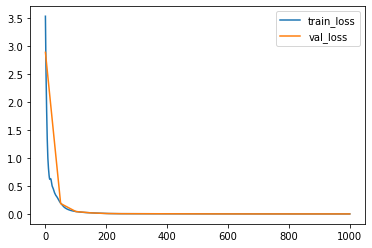

In [62]:
plt.plot(loss_LAE['train_loss'])
plt.plot(range(0, epochs+1, epochs//20), loss_LAE['val_loss'])
plt.legend(loss_LAE.keys())

In [63]:
print('mean:', statistics.mean(fe_loss_dict['LAE']), ', sd:', statistics.stdev(fe_loss_dict['LAE']))

mean: 24.28822666196855 , sd: 112.77483075262933


In [16]:
epochs = 100

##### Masked linear autoencoder (basic)

In [17]:
# grid search
search_score = []
search_record = {'params': -1, 'best_score': 1e8}

for prob in tqdm(prob_search):
    for i in range(epochs_grid):
        loss = 0

        net_MLAE_basic = M_LAE(prob, x_dim, f_dim).to(device)

        params = list(net_MLAE_basic.parameters())
        criterion = nn.MSELoss()
        optimizer = optim.Adam(params, lr=learning_rate)

        ### TRAINING ###
        if i==0 and prob==0.75:
            loss_MLAE_basic = train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=True, type='encoder')
        else:
            train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=False, type='encoder')
        loss += test_loop(data_dict, net_MLAE_basic, criterion, type='encoder')

    loss /= epochs_grid
    search_score.append(loss)
    if loss < search_record['best_score']:
        search_record['best_score'] = loss
        search_record['params'] = prob

 71%|███████▏  | 15/21 [21:17<08:57, 89.54s/it]

epoch:  0 , train loss:  3.5236145462201067 , val loss 2.865061627141473
epoch:  5 , train loss:  2.1886807504241026 , val loss 1.0661856624672534
epoch:  10 , train loss:  0.8025831753364375 , val loss 1.0722978307651918
epoch:  15 , train loss:  0.8079123554072127 , val loss 0.7402685838381435
epoch:  20 , train loss:  0.6243586970718239 , val loss 0.5899247235146451
epoch:  25 , train loss:  0.49562341318575237 , val loss 0.5028800126259475
epoch:  30 , train loss:  0.42060068984351423 , val loss 0.41873306006374206
epoch:  35 , train loss:  0.4012568121640055 , val loss 0.36987550940638064
epoch:  40 , train loss:  0.363194684659789 , val loss 0.3411346449372729
epoch:  45 , train loss:  0.35150673404167365 , val loss 0.3471333520997764
epoch:  50 , train loss:  0.33703679048922636 , val loss 0.33075695970460267
epoch:  55 , train loss:  0.3169723225221476 , val loss 0.3120387377037947
epoch:  60 , train loss:  0.3138737879712771 , val loss 0.2946338742144764
epoch:  65 , train los

100%|██████████| 21/21 [28:41<00:00, 81.97s/it]


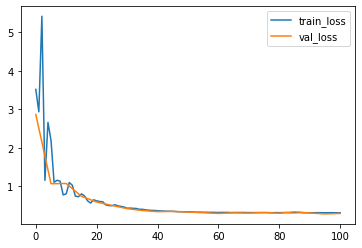

In [18]:
# training check at prob is 0.75
plt.plot(loss_MLAE_basic['train_loss'])
plt.plot(range(0, epochs+1, epochs//20), loss_MLAE_basic['val_loss'])
plt.legend(loss_MLAE_basic.keys())

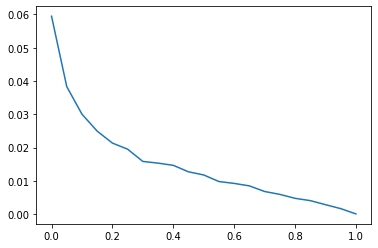

In [19]:
# search check
plt.plot(prob_search, search_score)

In [20]:
prob = search_record['params']
print('prob:', prob.item(), '\nloss:', loss)

prob: 1.0 
loss: 8.316570958423541e-05


In [21]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_basic = M_LAE(prob, x_dim, f_dim).to(device)

    params = list(net_MLAE_basic.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_basic.parameters(), criterion, type='ls', epochs=epochs)
    loss_ls = repr_learning(data_dict, net_MLAE_basic.parameters(), criterion, type='ls', epochs=epochs)
    fe_loss_dict['MLAE_basic'].append(loss_ls)

100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


In [22]:
print('mean:', statistics.mean(fe_loss_dict['MLAE_basic']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_basic']))

mean: 19.764446280136564 , sd: 130.27021268330387


##### Masked linear autoencoder (probs)

In [23]:
# grid search
search_score = []
search_record = {'params': -1, 'best_score': 1e8}

for count, prob_list in tqdm(enumerate(prob_list_search)):
    for i in range(epochs_grid):
        loss = 0

        net_MLAE_probs = M_LAE(prob_list, x_dim, f_dim, type='probs').to(device)

        params = list(net_MLAE_probs.parameters())
        criterion = nn.MSELoss()
        optimizer = optim.Adam(params, lr=learning_rate)

        ### TRAINING ###
        if i==0 and count==15:
            loss_MLAE_probs = train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=True, type='encoder')
        else:
            train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=False, type='encoder')
        loss += test_loop(data_dict, net_MLAE_probs, criterion, type='encoder')

    loss /= epochs_grid
    search_score.append(loss)
    if loss < search_record['best_score']:
        search_record['best_score'] = loss
        search_record['params'] = prob_list

15it [22:07, 88.03s/it]

epoch:  0 , train loss:  3.8981230818734094 , val loss 3.2475638325263945
epoch:  5 , train loss:  1.2318400841828028 , val loss 0.9943999861549803
epoch:  10 , train loss:  0.7784391384544415 , val loss 0.7396999064731535
epoch:  15 , train loss:  0.513999295205135 , val loss 0.4416857863800908
epoch:  20 , train loss:  0.3965432626393966 , val loss 0.40881985830014955
epoch:  25 , train loss:  0.3400049884062246 , val loss 0.34186522023998617
epoch:  30 , train loss:  0.28453224950353845 , val loss 0.2862950548423922
epoch:  35 , train loss:  0.263512414800827 , val loss 0.25662358779736677
epoch:  40 , train loss:  0.23655444030026157 , val loss 0.2515904538169924
epoch:  45 , train loss:  0.2307143921397011 , val loss 0.23151560968651722
epoch:  50 , train loss:  0.2194730673868675 , val loss 0.2194309589364305
epoch:  55 , train loss:  0.2215690966482557 , val loss 0.19939658236218444
epoch:  60 , train loss:  0.21565847842083224 , val loss 0.21534730013277734
epoch:  65 , train l

17it [24:39, 87.05s/it]


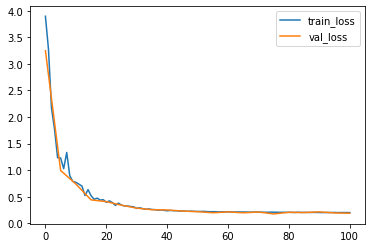

In [24]:
# training check at prob is 0.75
plt.plot(loss_MLAE_probs['train_loss'])
plt.plot(range(0, epochs+1, epochs//20), loss_MLAE_probs['val_loss'])
plt.legend(loss_MLAE_probs.keys())

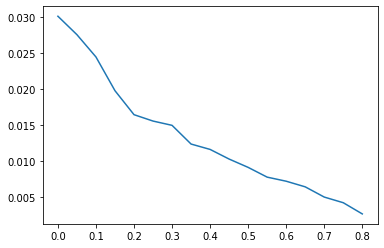

In [25]:
# search check
plt.plot(list(prob_search)[:17], search_score)

In [26]:
prob_list = search_record['params']
print('prob:', prob_list, '\nloss:', loss)

prob: tensor([0.9429, 0.9029, 0.8814, 0.8644, 0.8603, 0.8468, 0.9667, 0.9169, 0.8851,
        0.8440, 0.8102, 0.8919, 0.9371, 0.8715, 0.8871, 0.9910]) 
loss: 0.0026597472803311715


In [27]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_probs = M_LAE(prob_list, x_dim, f_dim, type='probs').to(device)

    params = list(net_MLAE_probs.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_probs.parameters(), criterion, type='ls', epochs=epochs)
    loss_ls = repr_learning(data_dict, net_MLAE_probs.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_probs'].append(loss_ls)

100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


In [28]:
print('mean:', statistics.mean(fe_loss_dict['MLAE_probs']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_probs']))

mean: 3.5287499164980014 , sd: 1.076605118355581


##### Masked linear autoencoder (patches)

In [29]:
# grid search
search_score = []
search_record = {'params': -1, 'best_score': 1e8}

for prob in tqdm(prob_search):
    for patch_size in patch_size_plain_search:
        for i in range(epochs_grid):
            loss = 0

            net_MLAE_patches = M_LAE(prob, x_dim, f_dim, type='patches', patch_size=patch_size).to(device)

            params = list(net_MLAE_patches.parameters())
            criterion = nn.MSELoss()
            optimizer = optim.Adam(params, lr=learning_rate)

            ### TRAINING ###
            if i==0 and prob==0.75 and patch_size==8:
                loss_MLAE_patches = train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=True, type='encoder')
            else:
                train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=False, type='encoder')
            loss += test_loop(data_dict, net_MLAE_patches, criterion, type='encoder')

        loss /= epochs_grid
        search_score.append(loss)
        if loss < search_record['best_score']:
            search_record['best_score'] = loss
            search_record['params'] = (prob, patch_size)

 71%|███████▏  | 15/21 [56:46<23:09, 231.65s/it]

epoch:  0 , train loss:  3.4470821927190713 , val loss 5.483412515622795
epoch:  5 , train loss:  1.943485113474706 , val loss 1.8455046290404282
epoch:  10 , train loss:  1.2379300166643747 , val loss 1.0390361111116755
epoch:  15 , train loss:  0.87183961072065 , val loss 0.9698258530088092
epoch:  20 , train loss:  0.7329648009051073 , val loss 0.7636003589396255
epoch:  25 , train loss:  0.7141249326897958 , val loss 0.7114470782569564
epoch:  30 , train loss:  0.6114205369745516 , val loss 0.6184717169015469
epoch:  35 , train loss:  0.6101255839215479 , val loss 0.6739539796075108
epoch:  40 , train loss:  0.5641878901022932 , val loss 0.4930101495759635
epoch:  45 , train loss:  0.5488182143558743 , val loss 0.5694961942127819
epoch:  50 , train loss:  0.5346817932156357 , val loss 0.5136083966570711
epoch:  55 , train loss:  0.5185196371415086 , val loss 0.5636496737487203
epoch:  60 , train loss:  0.5030194995503866 , val loss 0.47615149237417637
epoch:  65 , train loss:  0.49

100%|██████████| 21/21 [1:18:32<00:00, 224.42s/it]


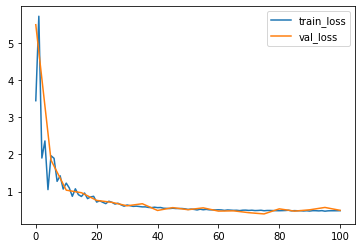

In [30]:
# training check at prob is 0.75
plt.plot(loss_MLAE_patches['train_loss'])
plt.plot(range(0, epochs+1, epochs//20), loss_MLAE_patches['val_loss'])
plt.legend(loss_MLAE_patches.keys())

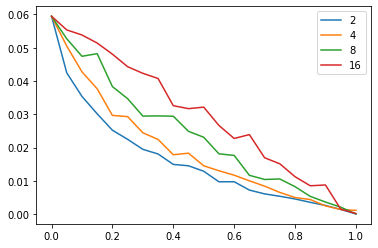

In [31]:
# search check
for i in range(4):
    plt.plot(prob_search, search_score[i::4])
plt.legend([str(patch_size.item()) for patch_size in patch_size_plain_search])

In [32]:
prob, patch_size = search_record['params']
print('prob:', prob, ',\npatch_size:', patch_size.item(), ',\nloss:', loss)

prob: tensor(1.) ,
patch_size: 2 ,
loss: 0.00017838464427819177


In [33]:
# feature extraction
fe_loss_dict['MLAE_patches'] = []
patch_size = 4
for i in tqdm(range(epochs_fe)):
    net_MLAE_patches = M_LAE(prob, x_dim, f_dim, type='patches', patch_size=patch_size).to(device)

    params = list(net_MLAE_patches.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='ls', epochs=epochs)
    loss_ls = repr_learning(data_dict, net_MLAE_patches.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_patches'].append(loss_ls)

100%|██████████| 100/100 [01:50<00:00,  1.10s/it]


In [34]:
print('mean:', statistics.mean(fe_loss_dict['MLAE_patches']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_patches']))

mean: 3.500800313630066 , sd: 0.827311253735518


### Evaluation

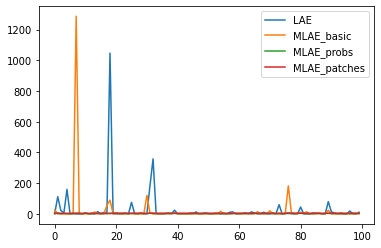

In [64]:
plt.plot(fe_loss_dict['LAE'])
plt.plot(fe_loss_dict['MLAE_basic'])
plt.plot(fe_loss_dict['MLAE_probs'])
plt.plot(fe_loss_dict['MLAE_patches'])
plt.legend(['LAE', 'MLAE_basic', 'MLAE_probs', 'MLAE_patches'])

In [65]:
fe_stats_dict = {'LAE': {'mean': statistics.mean(fe_loss_dict['LAE']), 'sd': statistics.stdev(fe_loss_dict['LAE'])},
                 'MLAE_basic': {'mean': statistics.mean(fe_loss_dict['MLAE_basic']), 'sd': statistics.stdev(fe_loss_dict['MLAE_basic'])},
                 'MLAE_probs': {'mean': statistics.mean(fe_loss_dict['MLAE_probs']), 'sd': statistics.stdev(fe_loss_dict['MLAE_probs'])},
                 'MLAE_patches': {'mean': statistics.mean(fe_loss_dict['MLAE_patches']), 'sd': statistics.stdev(fe_loss_dict['MLAE_patches'])}}
print(fe_stats_dict)

{'LAE': {'mean': 24.28822666196855, 'sd': 112.77483075262933}, 'MLAE_basic': {'mean': 19.764446280136564, 'sd': 130.27021268330387}, 'MLAE_probs': {'mean': 3.5287499164980014, 'sd': 1.076605118355581}, 'MLAE_patches': {'mean': 3.500800313630066, 'sd': 0.827311253735518}}


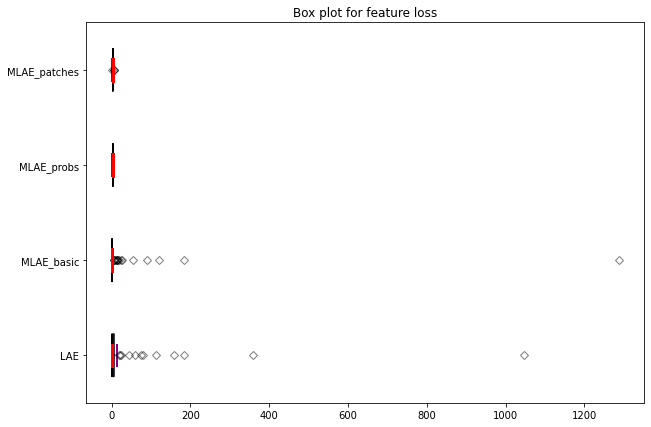

In [66]:
data = fe_loss_dict.values()
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 0)
 
colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_yticklabels(fe_loss_dict.keys())
#ax.set_yticklabels(patch_dict.keys())
 
# Adding title
plt.title("Box plot for feature loss")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()